# Chebyshev approximation of the inverse function

In this notebook we present the four ways of approximating the inverse function with Chebyshev polynomials:

1. Using Classiq's QSP application. Here the approximation can be made within an interval $[\lambda_\min, \lambda_\max]$, and the polynomial values are bounded in $[-1,1]$.
2. Using Numpy interpolation with a give degree, here the polynomial values are bounded in $[-1,1]$.
3. Using Numpy interpolation with the theoretical degree, and then trimming to a smaller degree.
4. Using an optimized (for the Maximum norm) expansion according to https://arxiv.org/pdf/2507.15537 (available in Classiq QSP application).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cheb_utils import *
from pauli_be import *
from scipy import sparse

from classiq.applications.chemistry.op_utils import qubit_op_to_qmod

In [2]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

We upload some matrix, and considered its block-encoding. We need the block-encoding scaling factor in order to calculate the effective range of singular/eigen-values.

In [3]:
mat_name = "nozzle_small_scr"
matfile = "matrices/" + mat_name + ".npz"
mat_raw_scr = sparse.load_npz(path / matfile)
rval = mat_raw_scr.data
col = mat_raw_scr.indices
rowstt = mat_raw_scr.indptr
nr = mat_raw_scr.shape[0]
data_size = int(np.log2(nr))
paulis_list, transform_matrix = initialize_paulis_from_csr(
    rowstt, col, data_size, to_symmetrize=False
)
qubit_op = eval_pauli_op(paulis_list, transform_matrix, rval)
qubit_op.compress(1e-12)
hamiltonian = qubit_op_to_qmod(qubit_op)

be_scaling_factor = sum([np.abs(term.coefficient) for term in hamiltonian.terms])

In [4]:
mat_raw = mat_raw_scr.toarray()

In [5]:
svd = np.linalg.svd(mat_raw / be_scaling_factor)[1]
w_min = min(svd)
w_max = max(svd)
scale = 0.5

degree = 101

print(f"min singular value: {min(svd)}, max_singular value: {max(svd)}")
pcoefs = get_cheb_coeff(
    w_min,
    degree,
    w_max=w_max,
    scale=scale,
    method="interpolated_in_range",
    epsilon=0.01,
)
pcoefs_trimmed = get_cheb_coeff(
    w_min, degree, w_max=w_max, scale=scale, method="numpy_trimmed", epsilon=0.01
)
pcoefs_approx = get_cheb_coeff(
    w_min, degree, w_max=w_max, scale=scale, method="numpy_interpolated", epsilon=0.01
)

pcoefs_optimized = get_cheb_coeff(
    w_min, degree, w_max=w_max, scale=scale, method="optimized", epsilon=0.01
)

min singular value: 0.02516479472045721, max_singular value: 0.589120855859263
For error 0.01, and given kappa, the needed polynomial degree is: 899
Performing convex optimization for the Chebyshev interpolation, with degree 101
For error 0.01, and given kappa, the needed polynomial degree is: 899
Performing numpy Chebyshev interpolation, with degree 899 and trimming to degree 101
For error 0.01, and given kappa, the needed polynomial degree is: 899
Performing numpy Chebyshev interpolation, with degree 101
For error 0.01, and given kappa, the needed polynomial degree is: 899
Taking optimized expansion from literature, with degree 101


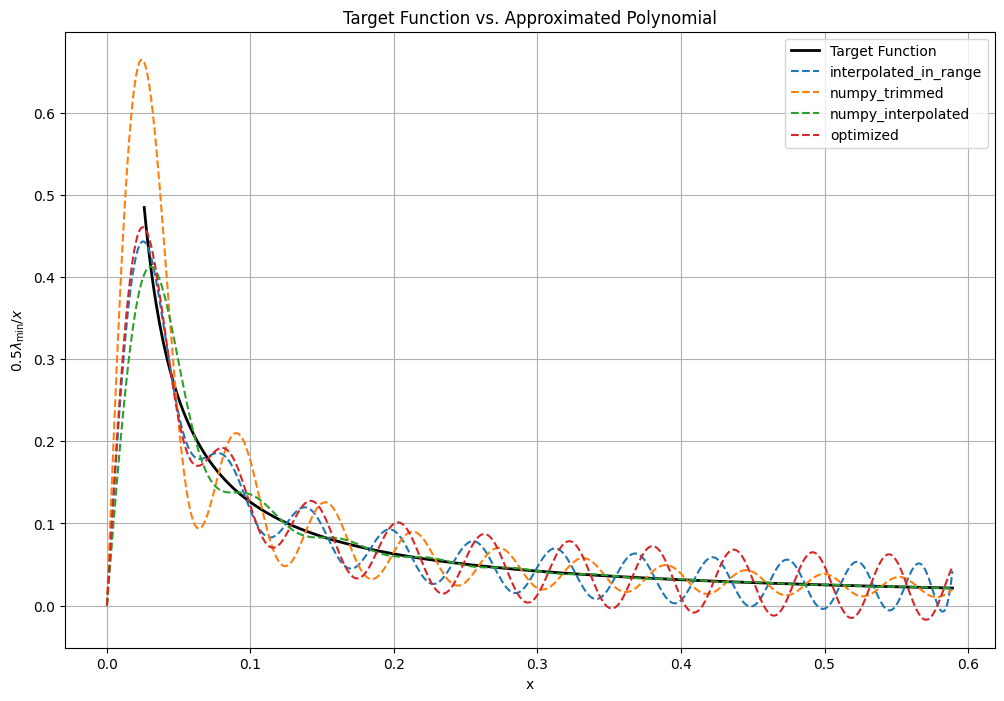

In [6]:
plot_cheb_inv_approx(
    {
        "interpolated_in_range": pcoefs,
        "numpy_trimmed": pcoefs_trimmed,
        "numpy_interpolated": pcoefs_approx,
        "optimized": pcoefs_optimized,
    },
    w_min,
    w_max,
    scale,
    half_space=True,
)